In [1]:
import os
import glob

from typing import Tuple, List, Union

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

import attn_dl
import attn_model
import scoring

In [2]:
torch.manual_seed(0)

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Model Training

In [4]:
def ou_loss(output, target):
    loss = 0
    i = 0
    while i < len(output) - 1:
        loss += abs(target[i] + target[i+1] - output[i] - output[i+1])
        i += 2
    return loss/(len(output)/2.)

In [5]:
def spread_loss(output, target):
    loss = 0
    i = 0
    while i < len(output) - 1:
        loss += abs((target[i+1] - target[i]) - (output[i+1] - output[i]))
        i += 2
    return loss/(len(output)/2.)

In [6]:
# Roughly follows https://pytorch.org/tutorials/beginner/nn_tutorial.html#

# Model hyperparameters
num_epochs = 50
batch_size = 32
learning_rate = 0.0001

### Training 8 Head Model

In [7]:
loss_func = F.smooth_l1_loss
model1, losses1 = attn_model.train_model(num_epochs, batch_size, learning_rate, heads = 8, depth = 2, loss_func= loss_func)

Training Model
tensor(178.7072, dtype=torch.float64)
50/50  [==============================] - 120.1s


In [9]:
_, x_train, y_train = attn_dl.load_vectorized_data('train')
_, x_validate, y_validate = attn_dl.load_vectorized_data('dev')

In [10]:
# Training error
train_diff = loss_func(model1(x_train), y_train).detach()
print("Training Error: ", train_diff)

## Validation Performance
# Total Loss on Validation Set
total_diff = loss_func(model1(x_validate), y_validate).detach()
print("Validation Error: ", total_diff)

# Error on test set
i_test, x_test, y_test = attn_dl.load_vectorized_data('test')
y_predicted = model1(x_test)
print("Test Error: ", loss_func(y_predicted, y_test))

Training Error:  tensor(8.0081, dtype=torch.float64)
Validation Error:  tensor(9.5791, dtype=torch.float64)
Test Error:  tensor(9.4492, dtype=torch.float64, grad_fn=<SmoothL1LossBackward>)


### Visualizing Attention Weights

In [11]:
attn_weights_8 = np.array([x.detach().numpy() for x in attn_model.get_weights()])

In [12]:
featnames = ['C1', 'F1', 'F2', 'G1', 'G2', 'S1', 'HOME']

In [56]:
# mean over multiple heads
avg = np.mean(np.mean(np.stack(attn_weights_8[-64:-32]), axis = 0), axis = 0)

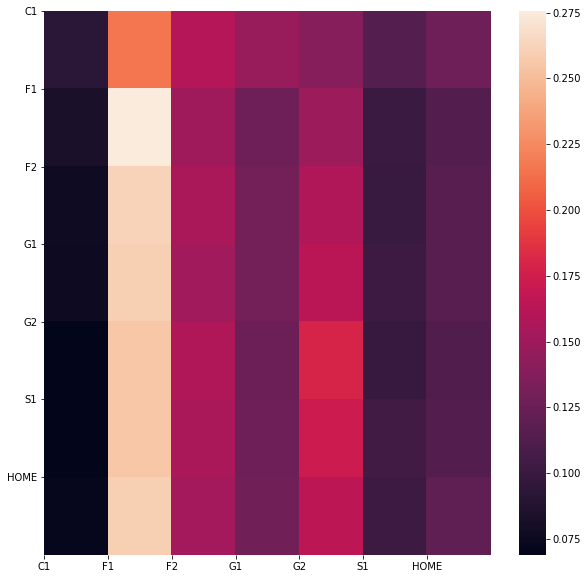

In [57]:
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(avg)
ax.set_xticks(range(7))
ax.set_xticklabels(featnames)
ax.set_yticks(range(7))
ax.set_yticklabels(featnames, rotation = 0)
plt.show()

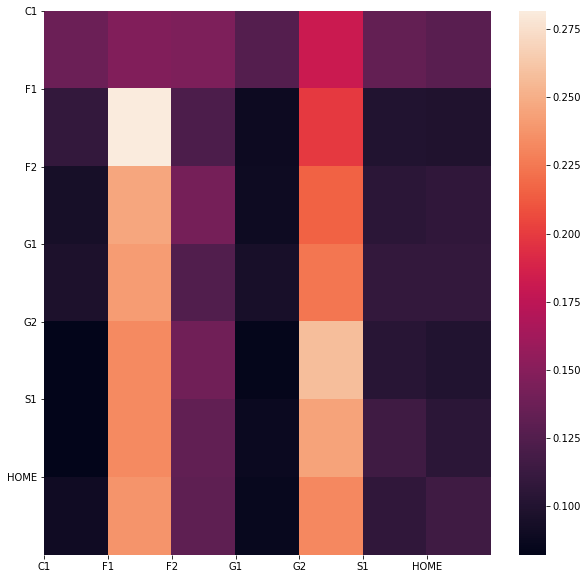

In [28]:
# Single head in the last layer, what does it learn?
last_layer_attn = np.mean(attn_weights_8[-4], axis = 0)
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(last_layer_attn)
ax.set_xticks(range(7))
ax.set_xticklabels(featnames)
ax.set_yticks(range(7))
ax.set_yticklabels(featnames, rotation = 0)
plt.show()

In [29]:
_, x_train, y_train = attn_dl.load_vectorized_data('train')
_, x_validate, y_validate = attn_dl.load_vectorized_data('dev')

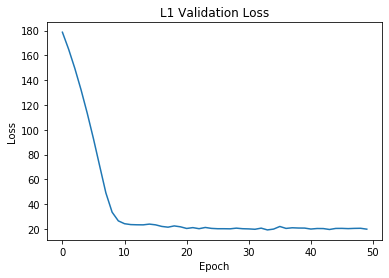

In [30]:
plt.title('L1 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(losses1)
plt.show()

### Training the 16 Head Model

In [31]:
model2, losses2 = attn_model.train_model(num_epochs, batch_size, learning_rate, heads = 16, depth = 2, loss_func= loss_func)

Training Model
tensor(180.1399, dtype=torch.float64)
50/50  [==============================] - 213.6s


In [32]:
# Training error
train_diff = loss_func(model2(x_train), y_train).detach()
print("Training Error: ", train_diff)

## Validation Performance
# Total Loss on Validation Set
total_diff = loss_func(model2(x_validate), y_validate).detach()
print("Validation Error: ", total_diff)

# Error on test set
i_test, x_test, y_test = attn_dl.load_vectorized_data('test')
y_predicted = model2(x_test)
print("Test Error: ", loss_func(y_predicted, y_test))

Training Error:  tensor(7.9651, dtype=torch.float64)
Validation Error:  tensor(9.4436, dtype=torch.float64)
Test Error:  tensor(9.2158, dtype=torch.float64, grad_fn=<SmoothL1LossBackward>)


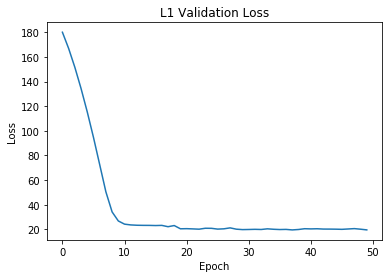

In [33]:
plt.title('L1 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(losses2)
plt.show()

### Visualizing Attention in 16 Head Model

In [38]:
attn_weights_16 = np.array([x.detach().numpy() for x in attn_model.get_weights()])

In [58]:
avg_16 = np.mean(np.mean(np.stack(attn_weights_16[-64:-32]), axis = 0), axis = 0)

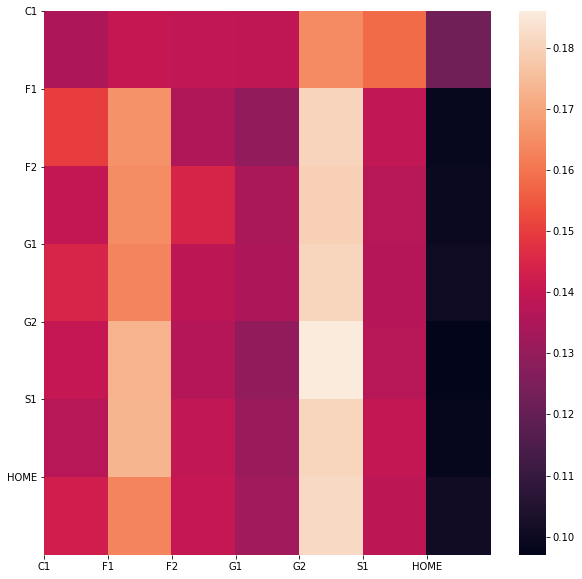

In [59]:
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(avg_16)
ax.set_xticks(range(7))
ax.set_xticklabels(featnames)
ax.set_yticks(range(7))
ax.set_yticklabels(featnames, rotation = 0)
plt.show()

## Model Evaluation

### 8 Head Transformer Results

In [26]:
# OVER/UNDER results at the CLOSE
header = '\t b won lost push  win% push%'
print(header)
print( '\t' + '-' * len(header))
for b in range(0, 35, 1):
    won, lost, pushed = scoring.score(model1, 'over/under', 'close', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 489  507    0 0.491 0.000
	 1 445  478   73 0.482 0.073
	 2 408  434  154 0.485 0.155
	 3 371  399  226 0.482 0.227
	 4 331  361  304 0.478 0.305
	 5 294  321  381 0.478 0.383
	 6 261  292  443 0.472 0.445
	 7 226  250  520 0.475 0.522
	 8 201  224  571 0.473 0.573
	 9 183  189  624 0.492 0.627
	10 172  162  662 0.515 0.665
	11 154  139  703 0.526 0.706
	12 131  117  748 0.528 0.751
	13 111   96  789 0.536 0.792
	14  97   82  817 0.542 0.820
	15  80   72  844 0.526 0.847
	16  67   63  866 0.515 0.869
	17  62   49  885 0.559 0.889
	18  42   38  916 0.525 0.920
	19  34   28  934 0.548 0.938
	20  29   22  945 0.569 0.949
	21  23   16  957 0.590 0.961
	22  19   13  964 0.594 0.968
	23  14   10  972 0.583 0.976
	24  11   10  975 0.524 0.979
	25  10    9  977 0.526 0.981
	26  10    7  979 0.588 0.983
	27   8    5  983 0.615 0.987
	28   6    4  986 0.600 0.990
	29   4    4  988 0.500 0.992
	30   3    3  990 0.500 0.994
	31   2  

In [29]:
# OVER/UNDER results at the OPEN
header = '\t b won lost push  win% push%'
print(header)
print('\t' + '-' * len(header))
for b in range(0, 30, 1):
    won, lost, pushed = scoring.score(model1, 'over/under', 'open', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 481  515    0 0.483 0.000
	 1 451  464   81 0.493 0.081
	 2 417  424  155 0.496 0.156
	 3 380  386  230 0.496 0.231
	 4 358  347  291 0.508 0.292
	 5 324  308  364 0.513 0.365
	 6 291  268  437 0.521 0.439
	 7 262  240  494 0.522 0.496
	 8 226  205  565 0.524 0.567
	 9 208  183  605 0.532 0.607
	10 176  155  665 0.532 0.668
	11 157  137  702 0.534 0.705
	12 137  118  741 0.537 0.744
	13 113   95  788 0.543 0.791
	14  99   80  817 0.553 0.820
	15  79   67  850 0.541 0.853
	16  66   54  876 0.550 0.880
	17  53   44  899 0.546 0.903
	18  46   35  915 0.568 0.919
	19  36   29  931 0.554 0.935
	20  28   24  944 0.538 0.948
	21  23   22  951 0.511 0.955
	22  23   19  954 0.548 0.958
	23  19   15  962 0.559 0.966
	24  15   12  969 0.556 0.973
	25  11    7  978 0.611 0.982
	26  10    6  980 0.625 0.984
	27   9    4  983 0.692 0.987
	28   7    3  986 0.700 0.990
	29   7    3  986 0.700 0.990


In [28]:
# SPREAD results at the CLOSE
header = '\t b won lost push  win% push%'
print(header)
print( '\t' + '-' * len(header))
for b in range(0, 20, 1):
    won, lost, pushed = scoring.score(model1, 'spread', 'close', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 478  518    0 0.480 0.000
	 1 391  440  165 0.471 0.166
	 2 313  353  330 0.470 0.331
	 3 253  258  485 0.495 0.487
	 4 202  190  604 0.515 0.606
	 5 146  140  710 0.510 0.713
	 6 105  100  791 0.512 0.794
	 7  78   70  848 0.527 0.851
	 8  52   52  892 0.500 0.896
	 9  36   34  926 0.514 0.930
	10  26   17  953 0.605 0.957
	11  20   11  965 0.645 0.969
	12  14   11  971 0.560 0.975
	13   8    8  980 0.500 0.984
	14   4    6  986 0.400 0.990
	15   3    3  990 0.500 0.994
	16   1    2  993 0.333 0.997
	17   0    2  994 0.000 0.998
	18   0    0  996 0.000 1.000
	19   0    0  996 0.000 1.000


In [37]:
# SPREAD results at the OPEN
header = '\t b won lost push  win% push%'
print(header)
print( '\t' + '-' * len(header))
for b in range(0, 20, 1):
    won, lost, pushed = scoring.score(model1, 'spread', 'open', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 501  495    0 0.503 0.000
	 1 452  442  102 0.506 0.102
	 2 397  393  206 0.503 0.207
	 3 346  344  306 0.501 0.307
	 4 297  309  390 0.490 0.392
	 5 256  266  474 0.490 0.476
	 6 222  233  541 0.488 0.543
	 7 198  198  600 0.500 0.602
	 8 167  163  666 0.506 0.669
	 9 141  125  730 0.530 0.733
	10 101   99  796 0.505 0.799
	11  80   72  844 0.526 0.847
	12  60   47  889 0.561 0.893
	13  43   28  925 0.606 0.929
	14  30   23  943 0.566 0.947
	15  19   15  962 0.559 0.966
	16  15    9  972 0.625 0.976
	17  11    4  981 0.733 0.985
	18   6    2  988 0.750 0.992
	19   2    1  993 0.667 0.997


### 16 Head Transformer Results

In [34]:
# OVER/UNDER results at the CLOSE
header = '\t b won lost push  win% push%'
print(header)
print( '\t' + '-' * len(header))
for b in range(0, 35, 1):
    won, lost, pushed = scoring.score(model2, 'over/under', 'close', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 493  503    0 0.495 0.000
	 1 457  450   89 0.504 0.089
	 2 399  411  186 0.493 0.187
	 3 361  361  274 0.500 0.275
	 4 317  323  356 0.495 0.357
	 5 277  277  442 0.500 0.444
	 6 237  250  509 0.487 0.511
	 7 204  213  579 0.489 0.581
	 8 187  187  622 0.500 0.624
	 9 165  153  678 0.519 0.681
	10 137  121  738 0.531 0.741
	11 115  105  776 0.523 0.779
	12  95   88  813 0.519 0.816
	13  83   72  841 0.535 0.844
	14  67   56  873 0.545 0.877
	15  55   46  895 0.545 0.899
	16  40   35  921 0.533 0.925
	17  34   31  931 0.523 0.935
	18  28   23  945 0.549 0.949
	19  22   18  956 0.550 0.960
	20  15   13  968 0.536 0.972
	21   9   11  976 0.450 0.980
	22   8   10  978 0.444 0.982
	23   5   10  981 0.333 0.985
	24   5    6  985 0.455 0.989
	25   5    5  986 0.500 0.990
	26   5    3  988 0.625 0.992
	27   1    3  992 0.250 0.996
	28   1    3  992 0.250 0.996
	29   1    3  992 0.250 0.996
	30   1    2  993 0.333 0.997
	31   1  

In [35]:
# OVER/UNDER results at the OPEN
header = '\t b won lost push  win% push%'
print(header)
print('\t' + '-' * len(header))
for b in range(0, 30, 1):
    won, lost, pushed = scoring.score(model2, 'over/under', 'open', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 512  484    0 0.514 0.000
	 1 466  443   87 0.513 0.087
	 2 426  402  168 0.514 0.169
	 3 385  351  260 0.523 0.261
	 4 351  310  335 0.531 0.336
	 5 304  264  428 0.535 0.430
	 6 265  230  501 0.535 0.503
	 7 229  206  561 0.526 0.563
	 8 198  177  621 0.528 0.623
	 9 166  145  685 0.534 0.688
	10 144  115  737 0.556 0.740
	11 120   94  782 0.561 0.785
	12  98   79  819 0.554 0.822
	13  88   67  841 0.568 0.844
	14  72   53  871 0.576 0.874
	15  52   48  896 0.520 0.900
	16  43   38  915 0.531 0.919
	17  35   29  932 0.547 0.936
	18  28   24  944 0.538 0.948
	19  23   18  955 0.561 0.959
	20  20   15  961 0.571 0.965
	21  12   13  971 0.480 0.975
	22  11   12  973 0.478 0.977
	23   9    9  978 0.500 0.982
	24   4    8  984 0.333 0.988
	25   3    5  988 0.375 0.992
	26   3    4  989 0.429 0.993
	27   3    3  990 0.500 0.994
	28   3    3  990 0.500 0.994
	29   3    3  990 0.500 0.994


In [36]:
# SPREAD results at the CLOSE
header = '\t b won lost push  win% push%'
print(header)
print( '\t' + '-' * len(header))
for b in range(0, 20, 1):
    won, lost, pushed = scoring.score(model2, 'spread', 'close', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 485  511    0 0.487 0.000
	 1 424  443  129 0.489 0.130
	 2 354  370  272 0.489 0.273
	 3 285  299  412 0.488 0.414
	 4 229  237  530 0.491 0.532
	 5 171  178  647 0.490 0.650
	 6 136  129  731 0.513 0.734
	 7  98   86  812 0.533 0.815
	 8  65   62  869 0.512 0.872
	 9  49   40  907 0.551 0.911
	10  37   29  930 0.561 0.934
	11  26   18  952 0.591 0.956
	12  23   17  956 0.575 0.960
	13  15   11  970 0.577 0.974
	14   5    5  986 0.500 0.990
	15   4    1  991 0.800 0.995
	16   3    0  993 1.000 0.997
	17   2    0  994 1.000 0.998
	18   2    0  994 1.000 0.998
	19   2    0  994 1.000 0.998


In [37]:
# SPREAD results at the OPEN
header = '\t b won lost push  win% push%'
print(header)
print( '\t' + '-' * len(header))
for b in range(0, 20, 1):
    won, lost, pushed = scoring.score(model2, 'spread', 'open', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 499  497    0 0.501 0.000
	 1 440  413  143 0.516 0.144
	 2 377  336  283 0.529 0.284
	 3 296  276  424 0.517 0.426
	 4 232  216  548 0.518 0.550
	 5 170  161  665 0.514 0.668
	 6 131  119  746 0.524 0.749
	 7  93   92  811 0.503 0.814
	 8  73   62  861 0.541 0.864
	 9  55   39  902 0.585 0.906
	10  43   29  924 0.597 0.928
	11  29   23  944 0.558 0.948
	12  22   15  959 0.595 0.963
	13  14    8  974 0.636 0.978
	14   8    4  984 0.667 0.988
	15   7    2  987 0.778 0.991
	16   5    1  990 0.833 0.994
	17   5    0  991 1.000 0.995
	18   4    0  992 1.000 0.996
	19   4    0  992 1.000 0.996
